## Welcome to the NeuroNest tutorial on EEG data preprocessing and visualization!

*Tutorial time*: 35 min

In this notebook, we'll cover several fundamental concepts that are essential for processing and visualizing EEG signals.

### Steps in EEG Data Preprocessing:
1. Importing Required Libraries: Load the necessary Python
libraries for EEG data processing.
2. Dowload the Data
3. Load the Dataset: Import the EEG dataset for analysis.
4. Filtering to Remove Noise: Apply filters to clean the data by removing unwanted noise.
5. Artifact Rejection: Identify and remove artifacts, such as eye blinks, that can distort the data.
6. Final Checks: Ensure the data is clean and ready for analysis.

### Tutorial Overview:
We'll focus on a single subject with resting-state EEG data. First, we'll visualize the raw EEG data to identify eye blink artifacts. Then, we'll apply Independent Component Analysis (ICA) to isolate and remove these artifacts. Finally, we'll visualize the cleaned EEG timeseries to observe the improvements.

### Dataset:
For this tutorial, we'll use a dataset from OpenNeuro. It can be found at:

Yulin Wang, Wei Duan, Debo Dong, Lihong Ding, Xu Lei (2022). A test-retest resting and cognitive state EEG dataset. OpenNeuro. [Dataset] doi:10.18112/openneuro.ds004148.v1.0.1

#### Let's get started with the preprocessing and visualization of EEG data!

# Step 1: Install Libraries

1. To import data into python, we will use functions of the MNE package. MNE is an open-source Python package for exploring, visualizing, and analyzing human neurophysiological data.

2. The AWS Command Line Interface (AWS CLI) is a unified tool to manage your AWS services. To use the AWS CLI for data download, particularly from an Amazon S3 bucket, we will use the aws s3 commands.

In [ ]:
# Install necessary libraries
!pip install mne > /dev/null 2>&1
!pip install awscli > /dev/null 2>&1

In [ ]:
%matplotlib inline

# Step 2: Dowload Dataset


* We select a specific subject and specify the EEG-related files to download from the OpenNeuro dataset.

* We then iterate through the list of files and use the AWS CLI to copy each file from the OpenNeuro S3 bucket to the local directory for further analysis.


Note: Here we are selecting a subseciton of the data so it wont take too long to load.


In [ ]:
# Select one subject
subjects = [f"sub-{i:02d}" for i in range(1, 2)]

# Specific files to download
files_to_download = [
    "eeg/{subject}_ses-session1_task-eyesopen_channels.tsv",
    "eeg/{subject}_ses-session1_task-eyesopen_eeg.eeg",
    "eeg/{subject}_ses-session1_task-eyesopen_eeg.json",
    "eeg/{subject}_ses-session1_task-eyesopen_eeg.vhdr",
    "eeg/{subject}_ses-session1_task-eyesopen_eeg.vmrk",
    "eeg/{subject}_ses-session1_task-eyesopen_events.tsv",
]

# Download the subject files
for subject in subjects:
    for file_pattern in files_to_download:
        file_path = file_pattern.format(subject=subject)
        full_path = f"{subject}/ses-session1/{file_path}"
        !aws s3 cp --no-sign-request s3://openneuro.org/ds004148/{full_path} ds004148-download/{full_path}


download: s3://openneuro.org/ds004148/sub-01/ses-session1/eeg/sub-01_ses-session1_task-eyesopen_channels.tsv to ds004148-download/sub-01/ses-session1/eeg/sub-01_ses-session1_task-eyesopen_channels.tsv
download: s3://openneuro.org/ds004148/sub-01/ses-session1/eeg/sub-01_ses-session1_task-eyesopen_eeg.eeg to ds004148-download/sub-01/ses-session1/eeg/sub-01_ses-session1_task-eyesopen_eeg.eeg
download: s3://openneuro.org/ds004148/sub-01/ses-session1/eeg/sub-01_ses-session1_task-eyesopen_eeg.json to ds004148-download/sub-01/ses-session1/eeg/sub-01_ses-session1_task-eyesopen_eeg.json
download: s3://openneuro.org/ds004148/sub-01/ses-session1/eeg/sub-01_ses-session1_task-eyesopen_eeg.vhdr to ds004148-download/sub-01/ses-session1/eeg/sub-01_ses-session1_task-eyesopen_eeg.vhdr
download: s3://openneuro.org/ds004148/sub-01/ses-session1/eeg/sub-01_ses-session1_task-eyesopen_eeg.vmrk to ds004148-download/sub-01/ses-session1/eeg/sub-01_ses-session1_task-eyesopen_eeg.vmrk
download: s3://openneuro.org/

# Step 3: Load data

* Define the path to the dataset and the specific channels file to analyze.

* Check if the channels file exists. If the file exists, load it into a DataFrame and display the channel names. If the file does not exist, print an error message indicating the missing file.

In [ ]:
import os

# Define the path to the dataset
data_path = 'ds004148-download'

# Define the path to the channels file (adjust the filename as necessary)
subject = "sub-01"  # Adjust the subject ID if different
channels_file = f"{data_path}/{subject}/ses-session1/eeg/{subject}_ses-session1_task-eyesopen_channels.tsv"

# Check if the file exists
if os.path.exists(channels_file):
    # Load the channels file into a DataFrame
    channels_df = pd.read_csv(channels_file, sep='\t')

    # Display the channel names
    print(channels_df['name'])
else:
    print(f"The file {channels_file} does not exist.")

0     Fp1
1     AF3
2     AF7
3      Fz
4      F1
     ... 
56     P8
57    POz
58    PO4
59    PO8
60     O2
Name: name, Length: 61, dtype: object


## Why we need to visualize the raw data

Visualizing raw EEG data is essential for identifying and understanding common artifacts, such as eye blinks, which can distort the signal.

Blink artifacts appear as large, distinct deflections in the EEG signal, typically seen in the example below in the frontopolar electrodes (Fp2, Fp1).  

These occur because the cornea (the positive pole) moves closer to the forehead electrodes during a blink, generating symmetric downward deflections. By examining the raw data, we can confirm the presence of these artifacts and understand their impact on signal quality, ensuring accurate identification and removal using methods like Independent Component Analysis (ICA).

*Image soure:* EEGpedia; http://www.eegpedia.org/index.php?title=Eye_blink_artifact



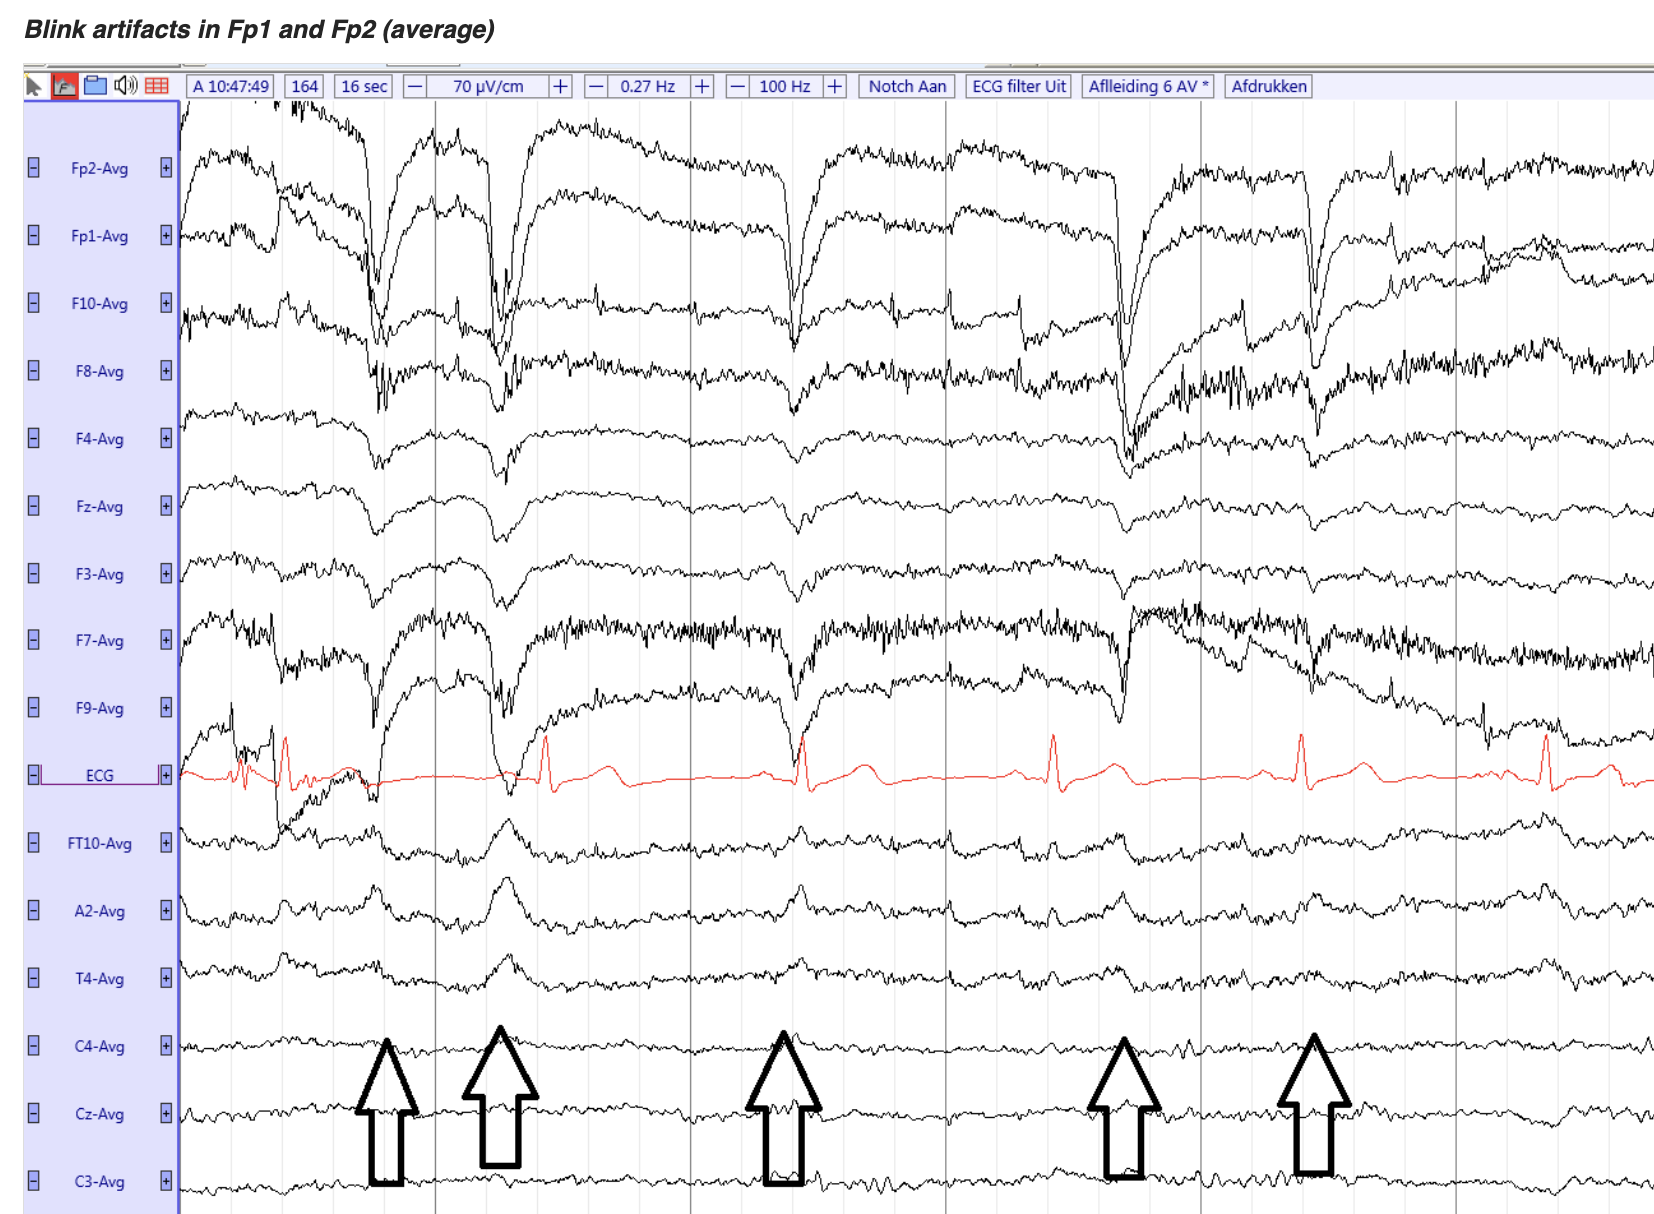

## Visualize raw data

* Define the path to our .vhdr file, which contains the metadata and structure for the EEG recording, and check if this file exists.

* If the file is present, load the raw EEG data using the MNE library, which allows us to handle and analyze electrophysiological data.

* Extract the first 50 seconds of this data to get a manageable segment for visualization.

* Create a new Raw object containing just this segment, and finally, we plot these first 50 seconds to visualize the EEG signals and inspect their quality. If the file does not exist, print an error message indicating the missing file.
```



Extracting parameters from ds004148-download/sub-01/ses-session1/eeg/sub-01_ses-session1_task-eyesopen_eeg.vhdr...
Setting channel info structure...
Reading 0 ... 149999  =      0.000 ...   299.998 secs...
Creating RawArray with float64 data, n_channels=61, n_times=25000
    Range : 0 ... 24999 =      0.000 ...    49.998 secs
Ready.


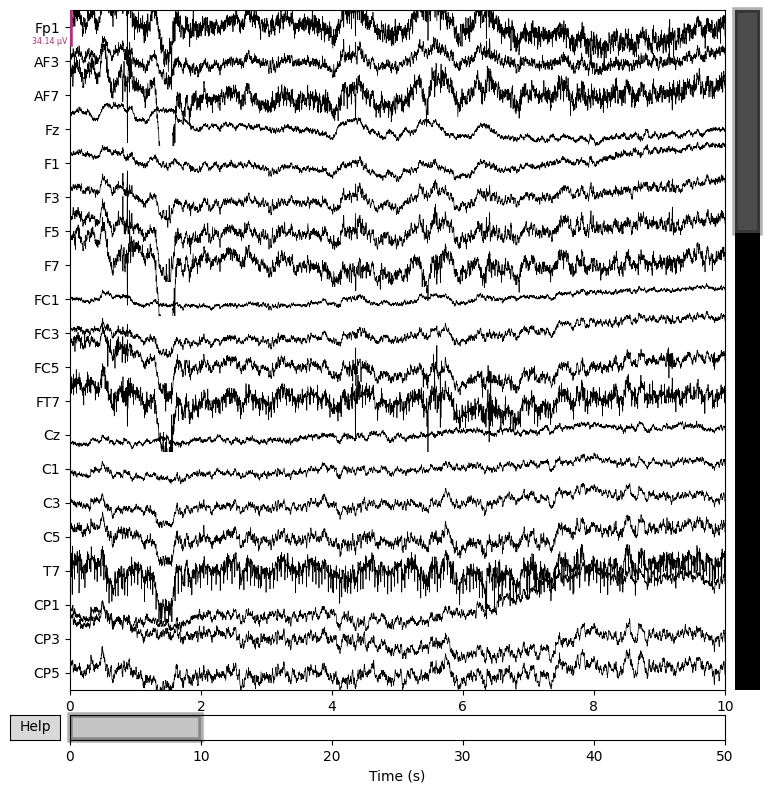

In [ ]:
import mne

# Define the path to the .vhdr file
vhdr_file = f"{data_path}/{subject}/ses-session1/eeg/{subject}_ses-session1_task-eyesopen_eeg.vhdr"

# Check if the file exists
if os.path.exists(vhdr_file):
    # Load the raw data using MNE
    raw = mne.io.read_raw_brainvision(vhdr_file, preload=True)

    # Extract the first few seconds of data (e.g., first 10 seconds)
    duration = 50  # seconds
    sfreq = raw.info['sfreq']  # sampling frequency
    start, stop = 0, int(sfreq * duration)
    data, times = raw[:, start:stop]

    # Create a Raw object with the first few seconds of data
    info = mne.create_info(raw.ch_names, sfreq, raw.get_channel_types())
    raw_first_few_seconds = mne.io.RawArray(data, info)

    # Plot the first few seconds of data
    raw_first_few_seconds.plot(scalings='auto', show=True, block=True)
else:
    print(f"The file {vhdr_file} does not exist.")

### Single Channel Isolation

As expected, we can see blink artifacts in our data just before the 10-second mark.

Let's isolate one channel and look at this more closely.


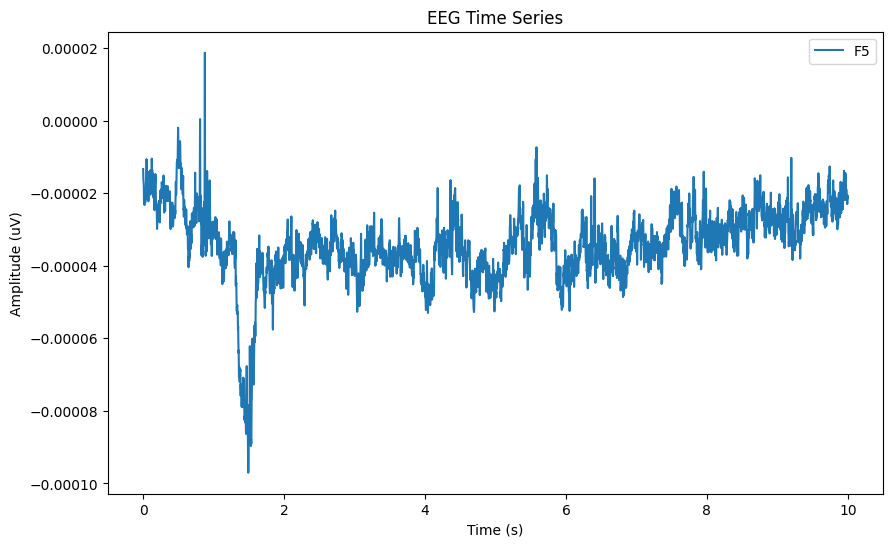

In [ ]:
import matplotlib.pyplot as plt

# Plot time series for selected channels
def plot_time_series(raw, channel_names, start, stop):
    # Convert channel names to indices
    channel_indices = [raw.ch_names.index(name) for name in channel_names]

    # Extract data and times
    data, times = raw[channel_indices, start:stop]

    # Plot the data
    plt.figure(figsize=(10, 6))
    for i, (channel, name) in enumerate(zip(channel_indices, channel_names)):
        plt.plot(times, data[i] + i * 50, label=name)  # offset each channel for clarity
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude (uV)')
    plt.title('EEG Time Series')
    plt.legend(loc='upper right')
    plt.show()

# Define the channel names and time range (first 10 seconds)
channel_names = ['F5']  # Adjust as needed
start, stop = 0, int(sfreq * 10)

# Plot the time series for the specified channels
plot_time_series(raw, channel_names, start, stop)


# Step 4: Filter the Data

#### Filter Your Data
Apply a bandpass filter to the data to remove unwanted frequencies. Here, the filter passes frequencies between 1 Hz and 50 Hz. Filtering is essential to remove noise and artifacts from the EEG data.

#### Why We Filter
Filtering the EEG data is crucial for several reasons:

* **Noise Reduction**: Removes low-frequency drifts and high-frequency noise that are not related to brain activity.
* **Improved Signal Quality**: Enhances the signal-to-noise ratio, making the neural signals more distinguishable.
* **Artifact Removal**: Helps eliminate physiological artifacts such as slow drifts, muscle activity, and electrical interference.


In [ ]:
 # Load a portion of the raw data (e.g., first 2 minutes)
raw = mne.io.read_raw_brainvision(vhdr_file, preload=True, verbose=False)
raw.crop(tmax=120)  # Load only the first 120 seconds (2 minutes)

# Downsample the data to 100 Hz
raw.resample(100, npad="auto")

# Apply a standard montage (e.g., 'standard_1020') for electrode locations
montage = mne.channels.make_standard_montage('standard_1020')
raw.set_montage(montage)

# Filter the data using an IIR filter
raw.filter(1., 50., method='iir')

# Step 5: Artifact Rejection

**Independent Component Analysis (ICA)** is used to identify and remove artifacts such as eye blinks and heartbeats from EEG data.

Effective artifact removal is *crucial* for accurate data analysis and interpretation, as eye blink artifacts can significantly impact EEG-based applications.

In this example, we fit an ICA model to the raw EEG data, identify components to exclude, and then apply the ICA solution to clean the data.


### How do we identify which ICA components to exclude?

We plot the ICA topoplots! By inspecting the ICA topoplots, we can identify components corresponding to blink artifacts. These components can then be excluded from the EEG data to remove the blink artifacts and clean the signal, ensuring that subsequent analyses are not distorted by these common sources of noise.

In [ ]:
from mne.preprocessing import ICA


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 1.00, 40.00 Hz: -6.02, -6.02 dB

Fitting ICA to data using 61 channels (please be patient, this may take a while)
Selecting by number: 20 components
Fitting ICA took 17.2s.


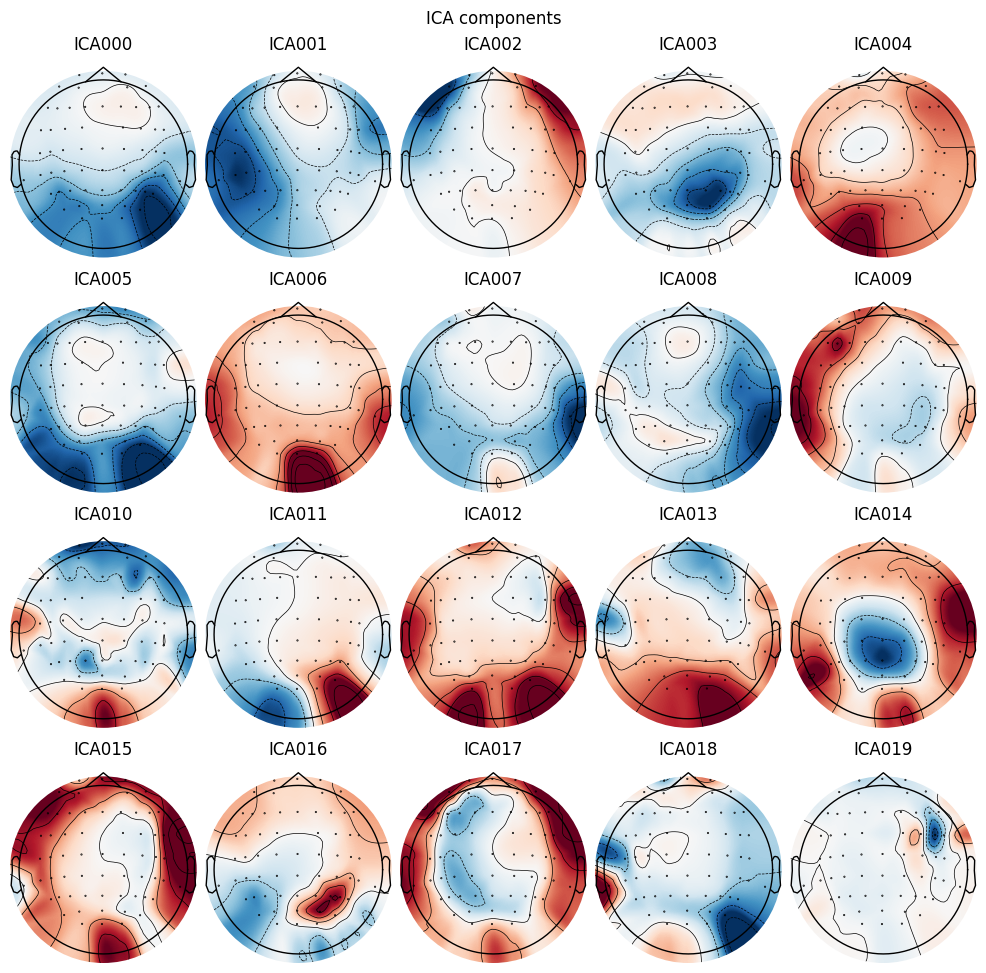

Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 1 ICA component
    Projecting back using 61 PCA components


In [ ]:
 # Load a portion of the raw data (e.g., first 2 minutes)
raw = mne.io.read_raw_brainvision(vhdr_file, preload=True, verbose=False)
raw.crop(tmax=120)  # Load only the first 120 seconds (2 minutes)

# Downsample the data to 100 Hz
raw.resample(100, npad="auto")

# Apply a standard montage (e.g., 'standard_1020')
montage = mne.channels.make_standard_montage('standard_1020')
raw.set_montage(montage)

# Filter the data using an IIR filter
raw.filter(1., 40., method='iir')

# Perform ICA
ica = ICA(n_components=20, random_state=97, max_iter='auto', verbose=False)
ica.fit(raw)

# Plot ICA components to visually inspect them
ica.plot_components()


#### Think! Which ICA component do you think corresponds to blinks?

##### Here is what to look for:

**Strong Frontal Activity:**
The topoplot of the blink component will show a strong, localized activity pattern in the frontal region of the scalp, especially around the electrodes near the eyes (Fp1, Fp2, F7, F8).

**Symmetric Distribution:**
Blink artifacts typically produce a symmetric pattern in the topoplot, centered on the midline of the forehead.

**Polarity:**
Look for a clear polarity change in the topoplot, with one side showing positive activity and the opposite side showing negative activity.

**Large Amplitude:**
The amplitude of the component in the frontal region is usually significantly higher than in other regions. This is due to the strong electrical signal generated by the movement of the cornea closer to the frontopolar electrodes during a blink.


#### ICA Topoplots Explained:

Here, we can see that ICA component #002 has the following:

*   Dipole pattern: The plot shows a clear dipole pattern with two regions of opposite polarity: one side is red (positive activity) and the other side is blue (negative activity). This kind of pattern is typical for eye blinks and other eye movements.

*   Frontal focus: The positive region (red) appears to be centered towards the forehead, which aligns with the location of the frontopolar electrodes (Fp1 and Fp2). This is consistent with the expected effect of eye blinks, where the cornea moves closer to these electrodes.

*   Symmetry: The plot demonstrates a fairly symmetric distribution across the midline of the head, another hallmark of eye blink artifacts.

Given these characteristics, this component (ICA002) is likely associated with eye blinks. The dipole pattern, strong frontal focus, and symmetric distribution are all indicators that this component captures the electrical activity generated by eye movements.

Next, we want to remove this artifact from our EEG data! 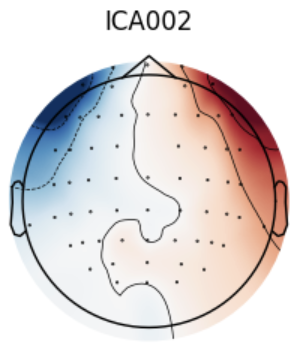


In [ ]:
# Manually identify components related to eye blinks and exclude them
ica.exclude = [2]  # Adjust based on your inspection

# Apply the ICA solution to the raw data
raw_clean = ica.apply(raw)

Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 1 ICA component
    Projecting back using 61 PCA components


# Step 5: Final checks

Visualize the ECG timeseries after performing ICA exclusion to see if you have removed the blink artifact.

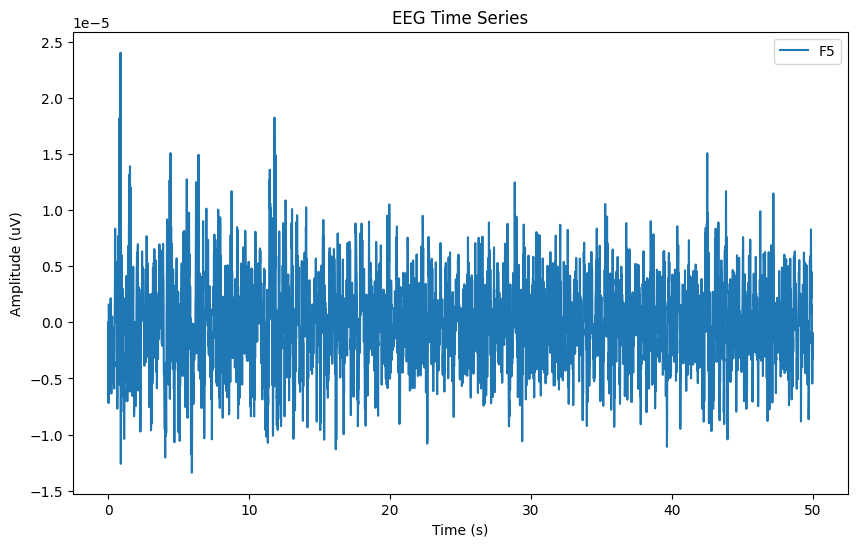

In [ ]:
# Define the channel names and time range (first 10 seconds)
# channel_names = ['F5']  # Adjust as needed
# start, stop = 0, int(raw.info['sfreq'] * 10)

# Plot the time series for the specified channels after artifact removal
plot_time_series(raw_clean, channel_names, start, stop)


Congrats! You have sucessfully removed the ICA component associated with the blink artifact. As you can see, there is no longer the large "bell" deflection in our EEG data.